In [1]:
from dataset.video import VideoDataset, collate_fn_for_text
import torch
import argparse



audio_process = argparse.Namespace(**{
    'duration'              : 10.0,
    'sample_rate'           : 16000,                                            # modified
    'channel_num'           : 1,      
})
video_process = argparse.Namespace(**{
    'duration'              : 10.0,
    'resize_input_size'     : [224, 224],        
    'target_sampling_rate'  : 10,
    'raw_duration_min_threshold' : 0.2       
})

infer_data = {
    'verbose': False,
    'load_mode_meta'      : None,
    'load_mode_item'      : 'video_feat_ref_text_with_waveform',
    'meta_dir'            : "/home/chengxin/chengxin/Dataset_Sound/MetaData/vaflow2_meta/meta",
    'split'               : "test_25_gtref_VGG",      # train_25_gtref_VGG | train_25_gtref_Chem_LRS2_GRID_VGG | train_25_ref_Chem_LRS2_GRID_VGG_LibriTTS_LJSpeech | train  |  train_speconly_ibtop_half   |  train_speconly
    'dilimeter'           : '|',
    'audio_process_config' : audio_process,
    'video_process_config' : video_process
}

dataset = VideoDataset(**infer_data)
batch_size = 1
dataloader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=batch_size, 
                                        shuffle=False, 
                                        num_workers=0, 
                                        prefetch_factor=None,
                                        persistent_workers=False,
                                        collate_fn=collate_fn_for_text)

In [4]:
from worker.vaflow_sda_dit_noise_mel import VAFlow
model_params = {
    "ckpt_dir_image_encoder": "/home/chengxin/chengxin/vasflow/model/clip/ckpt/ViT-B-16.pt",
    "ckpt_dir_audio_dit": "/home/chengxin/chengxin/vasflow/model/stable_audio/ckpt/transformer",
    "ckpt_dir_vocoder": "/data-04/xihua/data/ckpt/audioldm2/huggingface/vocoder",
    "vaflow_ckpt_path": "/home/chengxin/chengxin/vasflow/log_backup/2025_05_30-17_23_47-vaflow_sda_dit_noise_mel_10l_cct_first10/ckpt/epoch=0099-step=1.75e+05.ckpt", 
    "resume_training": False,  
    "ignore_keys": [],  # ['vaflow.preprocess_conv', 'vaflow.postprocess_conv', 'vaflow.proj_in', 'vaflow.proj_out']    # modified
    "phone_ebd_dim": 32,  
    "cond_feat_dim": 768,
    "dit_num_layers": 10, 
    # VAE setting
    "ckpt_dir_vae": "/data-04/xihua/data/ckpt/audioldm2/huggingface/vae",
    "vae_latent_scaling_factor": 1.0,
    "original_channel": 128,  
    "audio_length_per_sec": 25,  
    # Training setting
    "lr_warmup_steps": 2000,
    "use_cache_video_feat": True,  
    "unconditional_prob": 0.1,
    "scale_factor": 1.0,
    # Val and infer setting
    "guidance_scale": 3,
    "sample_steps": 10,
    "sample_method": "euler", # "midpoint",  # "euler"
    "num_samples_per_prompt"  : 1,
    "audio_sample_rate": 16000,  
    # PL training setting
    "monitor": None,
    "log_data_time": False  
}

model = VAFlow(**model_params)

Some weights of the model checkpoint at /home/chengxin/chengxin/vasflow/model/stable_audio/ckpt/transformer were not used when initializing StableAudioDiTModel: ['transformer_blocks.16.ff.net.0.proj.weight', 'transformer_blocks.13.attn2.to_out.0.weight', 'transformer_blocks.19.ff.net.2.weight', 'transformer_blocks.10.attn2.to_out.0.weight', 'transformer_blocks.15.attn2.to_q.weight', 'transformer_blocks.14.norm1.bias', 'transformer_blocks.21.attn1.to_q.weight', 'transformer_blocks.18.attn2.to_out.0.weight', 'transformer_blocks.18.ff.net.0.proj.bias', 'transformer_blocks.11.norm1.weight', 'transformer_blocks.20.attn1.to_q.weight', 'transformer_blocks.17.attn2.to_v.weight', 'transformer_blocks.12.attn2.to_v.weight', 'transformer_blocks.13.attn1.to_out.0.weight', 'transformer_blocks.17.norm2.bias', 'transformer_blocks.10.attn1.to_v.weight', 'transformer_blocks.21.attn2.to_out.0.weight', 'transformer_blocks.18.norm3.bias', 'transformer_blocks.19.norm1.bias', 'transformer_blocks.23.norm1.wei

=> Restored vaflow ckpt from /home/chengxin/chengxin/vasflow/log_backup/2025_05_30-17_23_47-vaflow_sda_dit_noise_mel_10l_cct_first10/ckpt/epoch=0099-step=1.75e+05.ckpt


In [5]:
import os

temp_dir = "./log/temp_log"
os.makedirs(temp_dir, exist_ok=True)
model.val_log_dir_for_video_per_epoch = temp_dir

for batch in dataloader:   
    re = model.predict_step(batch, batch_idx = 0)
    print(re)
    break

0.0


In [41]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from collections import defaultdict

attn_data = defaultdict(list)
attn_data['module'] = dict()
module_name = 'attn2'
hook_handles = []

def capture_query_key(name):
    def hook(module, input, output):
        print(name)
        attn_data[name].append([input[0], output])
    return hook

def capture_attn(name):
    def hook(module, input, output):
        print(name)
        attn_data['module'][name] = module
        attn_data[name].append([input])
    return hook


def register_hooks(model):
    global hook_handles
    for name, module in model.vaflow.named_modules():   
        if f"{module_name}.to_k" in name or f'{module_name}.to_q' in name:
            handle = module.register_forward_hook(capture_query_key(name))
            hook_handles.append(handle)
        if name.endswith(module_name):
            handle = module.register_forward_hook(capture_attn(name))
            hook_handles.append(handle)


def reset_hooks():
    global hook_handles
    for handle in hook_handles:
        handle.remove()
    hook_handles = []  # 清空句柄列表
    attn_data.clear()  # 清空注意力数据


def extract_and_visualize_attention(model, dataloader):
    model.eval()
    register_hooks(model)
    for batch_idx, batch in enumerate(dataloader):
        with torch.no_grad():
            output = model.predict_step(batch, batch_idx=0)
        print("Model output:", output)
        # for layer_name, data in attn_data.items():
            # print(f"Visualizing attention for layer: {layer_name}")
            # print(f"Input Length: {data['input_length']}")
            # visualize_attention_heatmap(data['attn_weights'], layer_name)
        break

extract_and_visualize_attention(model, dataloader)

transformer_blocks.0.attn2.to_q
transformer_blocks.0.attn2.to_k
transformer_blocks.0.attn2
transformer_blocks.1.attn2.to_q
transformer_blocks.1.attn2.to_k
transformer_blocks.1.attn2
transformer_blocks.2.attn2.to_q
transformer_blocks.2.attn2.to_k
transformer_blocks.2.attn2
transformer_blocks.3.attn2.to_q
transformer_blocks.3.attn2.to_k
transformer_blocks.3.attn2
transformer_blocks.4.attn2.to_q
transformer_blocks.4.attn2.to_k
transformer_blocks.4.attn2
transformer_blocks.5.attn2.to_q
transformer_blocks.5.attn2.to_k
transformer_blocks.5.attn2
transformer_blocks.6.attn2.to_q
transformer_blocks.6.attn2.to_k
transformer_blocks.6.attn2
transformer_blocks.7.attn2.to_q
transformer_blocks.7.attn2.to_k
transformer_blocks.7.attn2
transformer_blocks.8.attn2.to_q
transformer_blocks.8.attn2.to_k
transformer_blocks.8.attn2
transformer_blocks.9.attn2.to_q
transformer_blocks.9.attn2.to_k
transformer_blocks.9.attn2
transformer_blocks.0.attn2.to_q
transformer_blocks.0.attn2.to_k
transformer_blocks.0.attn2

In [32]:
# from diffusers.models.embeddings import apply_rotary_emb, get_1d_rotary_pos_embed

# layer = 0
# step = 10
# query = attn_data[f'transformer_blocks.{layer}.{module_name}.to_q'][step*2-1][-1]
# key = attn_data[f'transformer_blocks.{layer}.{module_name}.to_k'][step*2-1][-1]
# attn = attn_data['module'][f'transformer_blocks.{layer}.{module_name}']
# rotary_emb = get_1d_rotary_pos_embed(
#     model.rotary_embed_dim,
#     query.shape[1],      
#     use_real=True,
#     repeat_interleave_real=False,
# )

In [42]:
from diffusers.models.embeddings import apply_rotary_emb, get_1d_rotary_pos_embed

layer = 0
queries = [attn_data[f'transformer_blocks.{layer}.{module_name}.to_q'][s*2-1][-1] for s in range(1, 11)]
keys = [attn_data[f'transformer_blocks.{layer}.{module_name}.to_k'][s*2-1][-1] for s in range(1, 11)]
rotary_emb = get_1d_rotary_pos_embed(
    model.rotary_embed_dim,
    queries[0].shape[1],      
    use_real=True,
    repeat_interleave_real=False,
)

In [43]:
import math

attn_weights = []
for i in range(len(queries)):
    attn = attn_data['module'][f'transformer_blocks.{i}.{module_name}']
    query = queries[i].to(torch.float32)
    key = keys[i].to(torch.float32)
    head_dim = query.shape[-1] // attn.heads
    kv_heads = key.shape[-1] // head_dim

    query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
    key = key.view(batch_size, -1, kv_heads, head_dim).transpose(1, 2)

    if kv_heads != attn.heads:
        # if GQA or MQA, repeat the key/value heads to reach the number of query heads.
        heads_per_kv_head = attn.heads // kv_heads
        key = torch.repeat_interleave(key, heads_per_kv_head, dim=1)

    if attn.norm_q is not None:
        query = attn.norm_q(query)
    if attn.norm_k is not None:
        key = attn.norm_k(key)

    # Apply RoPE if needed
    if rotary_emb is not None:
        query_dtype = query.dtype
        key_dtype = key.dtype
        query = query.to(torch.float32)
        key = key.to(torch.float32)
        print(query.shape, key.shape, rotary_emb[0].shape, rotary_emb[1].shape)

        rot_dim = rotary_emb[0].shape[-1]
        query_to_rotate, query_unrotated = query[..., :rot_dim], query[..., rot_dim:]
        query_rotated = apply_rotary_emb(query_to_rotate, rotary_emb, use_real=True, use_real_unbind_dim=-2)

        query = torch.cat((query_rotated, query_unrotated), dim=-1)

        if not attn.is_cross_attention:
            key_to_rotate, key_unrotated = key[..., :rot_dim], key[..., rot_dim:]
            key_rotated = apply_rotary_emb(key_to_rotate, rotary_emb, use_real=True, use_real_unbind_dim=-2)

            key = torch.cat((key_rotated, key_unrotated), dim=-1)

        query = query.to(query_dtype)
        key = key.to(key_dtype)

        L, S = query.size(-2), key.size(-2)
        scale_factor = 1 / math.sqrt(query.size(-1)) 
        attn_bias = torch.zeros(L, S, dtype=query.dtype, device=query.device)

        attn_weight = query @ key.transpose(-2, -1) * scale_factor
        attn_weight += attn_bias
        attn_weight = torch.softmax(attn_weight, dim=-1)
        attn_weight = attn_weight.mean(1)
        attn_weights.append(attn_weight)

attn_weights = torch.concat(attn_weights, dim=0)

torch.Size([1, 24, 251, 64]) torch.Size([1, 24, 251, 64]) torch.Size([251, 32]) torch.Size([251, 32])
torch.Size([1, 24, 251, 64]) torch.Size([1, 24, 251, 64]) torch.Size([251, 32]) torch.Size([251, 32])
torch.Size([1, 24, 251, 64]) torch.Size([1, 24, 251, 64]) torch.Size([251, 32]) torch.Size([251, 32])
torch.Size([1, 24, 251, 64]) torch.Size([1, 24, 251, 64]) torch.Size([251, 32]) torch.Size([251, 32])
torch.Size([1, 24, 251, 64]) torch.Size([1, 24, 251, 64]) torch.Size([251, 32]) torch.Size([251, 32])
torch.Size([1, 24, 251, 64]) torch.Size([1, 24, 251, 64]) torch.Size([251, 32]) torch.Size([251, 32])
torch.Size([1, 24, 251, 64]) torch.Size([1, 24, 251, 64]) torch.Size([251, 32]) torch.Size([251, 32])
torch.Size([1, 24, 251, 64]) torch.Size([1, 24, 251, 64]) torch.Size([251, 32]) torch.Size([251, 32])
torch.Size([1, 24, 251, 64]) torch.Size([1, 24, 251, 64]) torch.Size([251, 32]) torch.Size([251, 32])
torch.Size([1, 24, 251, 64]) torch.Size([1, 24, 251, 64]) torch.Size([251, 32]) to

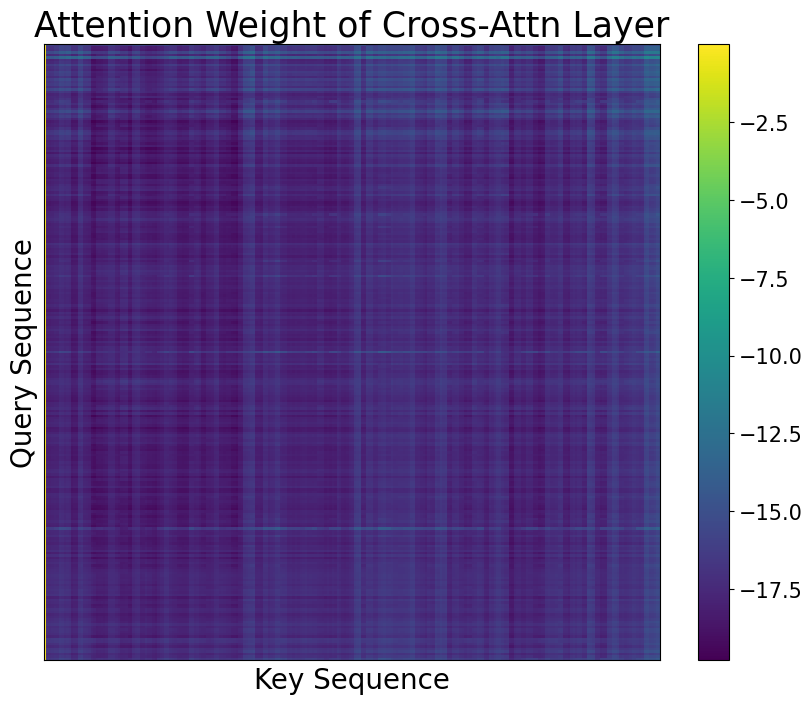

In [44]:
import numpy as np
def plot_attention_heatmap(attn_matrix):
    attn_matrix = np.log(attn_matrix + 1e-9)  # 加小值防止 log(0)
    plt.figure(figsize=(10, 8))
    plt.imshow(attn_matrix, cmap='viridis', interpolation='nearest')
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=15)
    plt.title(f'Attention Weight of Cross-Attn Layer',fontsize=25)
    plt.xlabel('Key Sequence',fontsize=20)
    plt.ylabel('Query Sequence',fontsize=20)
    plt.xticks([])  # 隐藏x轴坐标
    plt.yticks([])  # 隐藏y轴坐标
    plt.show()

plot_attention_heatmap(attn_weights[2])
reset_hooks()